In [25]:
# 1) Setup & safety switches (seeds, dataset path, speed knobs)
# I prepare imports, set seeds for reproducibility, and define where my dataset lives.

import os, glob, itertools, json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# I can speed up development runs with QUICK_RUN. For the final run, I set this to False.
QUICK_RUN = True   # True = faster debugging (fewer epochs/folds); False = full run for report

# I never touch the test set until the very end to avoid leakage.
RUN_FINAL_TEST = False

# I set seeds for reproducibility.
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
try:
    tf.config.experimental.enable_op_determinism(True)
except Exception:
    pass

# I define labels and image size. I use a slightly smaller size in quick runs for speed.
CLASSES  = ["paper", "rock", "scissors"]
IMG_SIZE = (128, 128) if QUICK_RUN else (150, 150)

# I detect where the dataset resides. I expect class folders named exactly: paper/rock/scissors.
CANDIDATES = ["data/raw", "data/raw/rockpaperscissors", "data"]
DATA_ROOT = None
for c in CANDIDATES:
    if all(os.path.isdir(os.path.join(c, d)) for d in CLASSES):
        DATA_ROOT = c
        break
if DATA_ROOT is None:
    raise FileNotFoundError(
        "I couldn't find 'paper/rock/scissors' under data/raw or data/raw/rockpaperscissors. "
        "I place the Kaggle folders there before running."
    )

print(f"I use DATA_ROOT={DATA_ROOT}, IMG_SIZE={IMG_SIZE}, QUICK_RUN={QUICK_RUN}")


I use DATA_ROOT=data/raw, IMG_SIZE=(128, 128), QUICK_RUN=True


In [26]:
# 2) Data exploration — index images, counts, quick table
# I thoroughly explore counts per class and inspect a small head of the table.

def index_images(root):
    X, y = [], []
    for ci, cname in enumerate(CLASSES):
        for ext in ("*.png", "*.jpg", "*.jpeg"):
            for fp in glob.glob(os.path.join(root, "**", cname, ext), recursive=True):
                X.append(fp); y.append(ci)
    return np.array(X), np.array(y, dtype=np.int32)

X_all, y_all = index_images(DATA_ROOT)
print("I found", len(X_all), "images total.")
counts = pd.Series(y_all).value_counts().sort_index()
print("Counts by class:")
for i, cname in enumerate(CLASSES):
    print(f"  {cname}: {int(counts.get(i, 0))}")
pd.DataFrame({"path": X_all, "label": y_all}).head()


I found 2188 images total.
Counts by class:
  paper: 712
  rock: 726
  scissors: 750


,path,label
0,data/raw/paper/W79peyAyfQqNP1vF.png,0
1,data/raw/paper/7ZGsbIMypDIEZxR0.png,0
2,data/raw/paper/DsaaqkHZUN3pmcwH.png,0
3,data/raw/paper/P1STllnKDD05zo29.png,0
4,data/raw/paper/RlpqfQnTgM6AxUNs.png,0


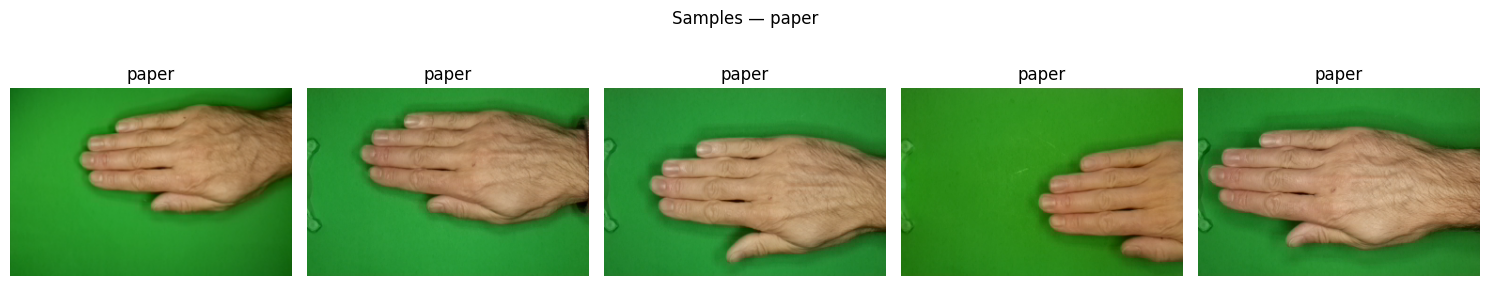

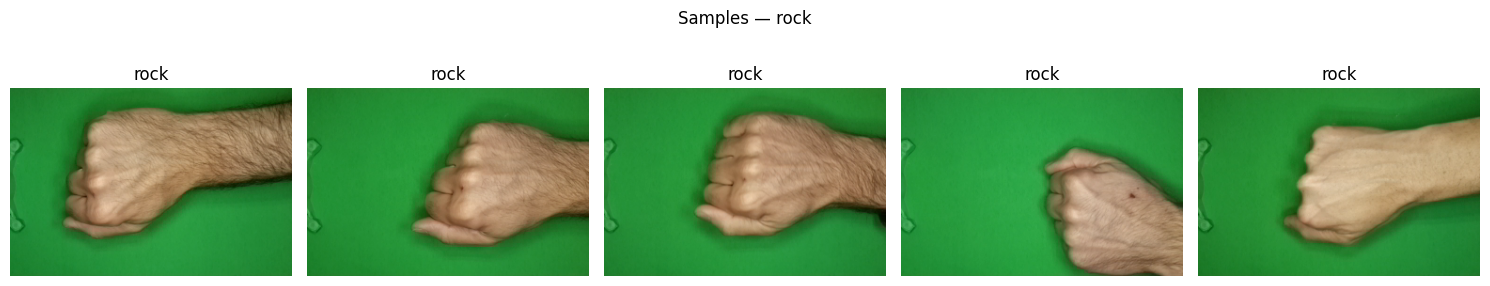

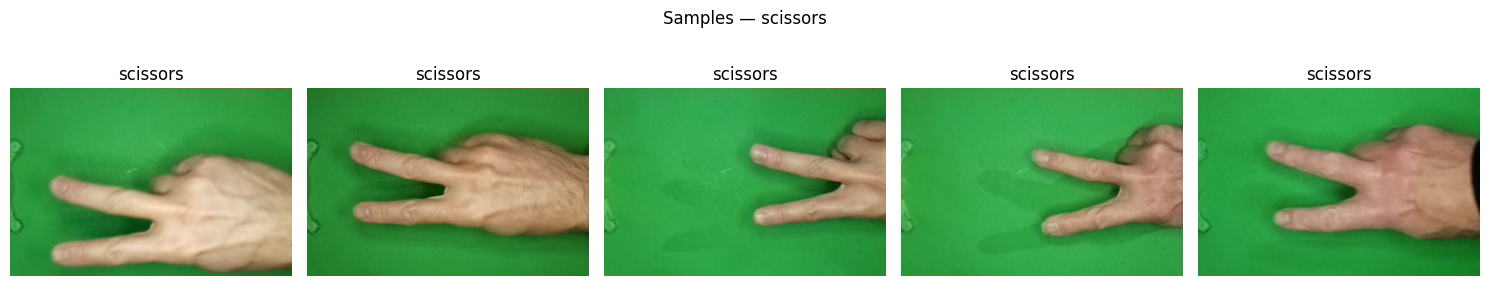

In [27]:
# Visual sanity-check: sample images per class (from DATA_ROOT)
# I visualize a few random images from each class to verify the dataset looks right.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rng = np.random.default_rng(SEED)

def _class_files(root, cname):
    files = []
    for ext in ("*.png", "*.jpg", "*.jpeg"):
        files += glob.glob(os.path.join(root, "**", cname, ext), recursive=True)
    return files

def show_samples(cname, n=5):
    files = _class_files(DATA_ROOT, cname)
    if not files:
        print("No images for", cname); return
    sel = files if len(files) <= n else rng.choice(files, size=n, replace=False)
    plt.figure(figsize=(3*len(sel), 3))
    for i, fp in enumerate(sel, 1):
        plt.subplot(1, len(sel), i)
        plt.imshow(mpimg.imread(fp))
        plt.title(cname); plt.axis("off")
    plt.suptitle(f"Samples — {cname}", y=1.02)
    plt.tight_layout(); plt.show()

for cname in CLASSES:
    show_samples(cname, n=5)


In [28]:
# 3) Fixed stratified splits — save to disk (prevents test leakage)
# I create a fixed train/val/test split once and save it, so I never leak test info during tuning.

X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.15, stratify=y_all, random_state=SEED
)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_tr, y_tr, test_size=0.20, stratify=y_tr, random_state=SEED
)

os.makedirs("splits", exist_ok=True)
def _save_list(arr, path):
    with open(path, "w") as f:
        for a in arr: f.write(a + "\n")

_save_list(X_tr, "splits/train.txt")
_save_list(X_va, "splits/val.txt")
_save_list(X_te, "splits/test.txt")

print("I saved: splits/train.txt, splits/val.txt, splits/test.txt")
(len(X_tr), len(X_va), len(X_te))

I saved: splits/train.txt, splits/val.txt, splits/test.txt


(1487, 372, 329)

In [29]:
# 4) Preprocessing pipeline — resize, normalize; augmentation on train only
# I resize to IMG_SIZE, normalize to [0,1], and apply simple augmentations only to training batches.

def load_split_list(txt):
    with open(txt) as f:
        files = [ln.strip() for ln in f if ln.strip()]
    labels = []
    for fp in files:
        lab = None
        norm = fp.replace("/", os.sep)
        for i, cname in enumerate(CLASSES):
            if os.sep + cname + os.sep in norm:
                lab = i; break
        if lab is None:
            raise ValueError(f"Cannot infer class for path: {fp}")
        labels.append(lab)
    return np.array(files), np.array(labels, dtype=np.int32)

def make_ds(filepaths, labels, img_size=IMG_SIZE, batch=32, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    def _load(fp, y):
        img = tf.io.read_file(fp)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img, y
    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).cache().prefetch(tf.data.AUTOTUNE)

# I load only train and val here. I keep test untouched until the end.
Xtr, ytr = load_split_list("splits/train.txt")
Xva, yva = load_split_list("splits/val.txt")

In [30]:
# 5) Three CNN architectures (Tiny, Base, Deep)

def TinyCNN(input_shape=(150,150,3), n_classes=3, dr=0.3):
    i = tf.keras.Input(input_shape)
    x = tf.keras.layers.Conv2D(32,3,padding="same")(i); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dr)(x)
    o = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(i, o, name="TinyCNN")

def BaseCNN(input_shape=(150,150,3), n_classes=3, dr1=0.4, dr2=0.5):
    i = tf.keras.Input(input_shape); x = i
    for f in [32,64,128]:
        x = tf.keras.layers.Conv2D(f,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(f,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dr1)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(dr2)(x)
    o = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(i, o, name="BaseCNN")

def DeepCNN(input_shape=(150,150,3), n_classes=3, dr=0.5):
    i = tf.keras.Input(input_shape); x = i
    for f in [32,64,128,256]:
        x = tf.keras.layers.SeparableConv2D(f,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.SeparableConv2D(f,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dr)(x)
    o = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(i, o, name="DeepCNN")



In [31]:
# 6) Train Tiny/Base/Deep; compare on validation

def compile_model(m, lr=1e-3):
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

BATCH  = 32
EPOCHS = 16 if QUICK_RUN else 40

train_ds = make_ds(Xtr, ytr, batch=BATCH, shuffle=True,  augment=True)
val_ds   = make_ds(Xva, yva, batch=BATCH, shuffle=False, augment=False)

models = [
    TinyCNN (input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BaseCNN (input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    DeepCNN (input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
]
histories = {}

for m in models:
    m = compile_model(m, lr=1e-3)
    cbs = [
        tf.keras.callbacks.EarlyStopping(patience=(5 if QUICK_RUN else 8), restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
    h = m.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cbs, verbose=1)
    histories[m.name] = h.history

print("I trained:", list(histories.keys()))



Epoch 1/16
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 614ms/step - accuracy: 0.4231 - loss: 1.1009 - val_accuracy: 0.3333 - val_loss: 1.0883 - learning_rate: 0.0010
Epoch 2/16
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5516 - loss: 0.9139 - val_accuracy: 0.3306 - val_loss: 1.1367 - learning_rate: 0.0010
Epoch 3/16
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6232 - loss: 0.8534 - val_accuracy: 0.3306 - val_loss: 1.2182 - learning_rate: 0.0010
Epoch 4/16
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.6600 - loss: 0.7813 - val_accuracy: 0.3306 - val_loss: 1.2710 - learning_rate: 0.0010
Epoch 5/16
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.6994 - loss: 0.7170 - val_accuracy: 0.3306 - val_loss: 1.4050 - learning_rate: 5.0000e-04
Epoch 6/16
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7382 - loss: 0.6824 - val_accuracy: 0.3306 - val_loss: 1.5201 - learning_rate: 5.0000e-04
Epoch 1/16
47/47 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.4876 - loss: 1.2227

I saved curves to reports/*.png


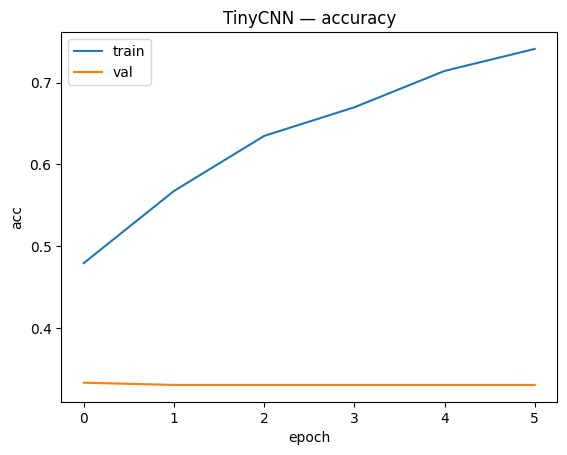

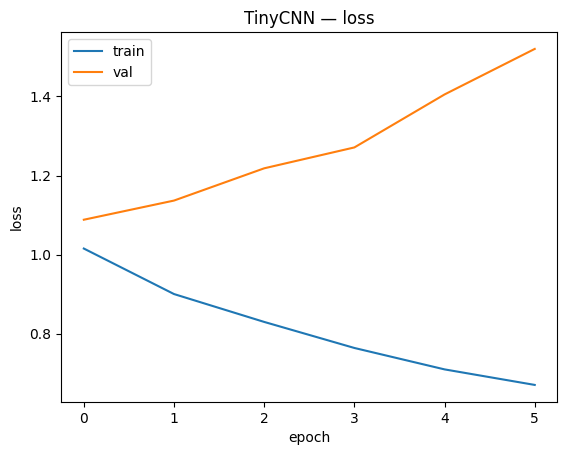

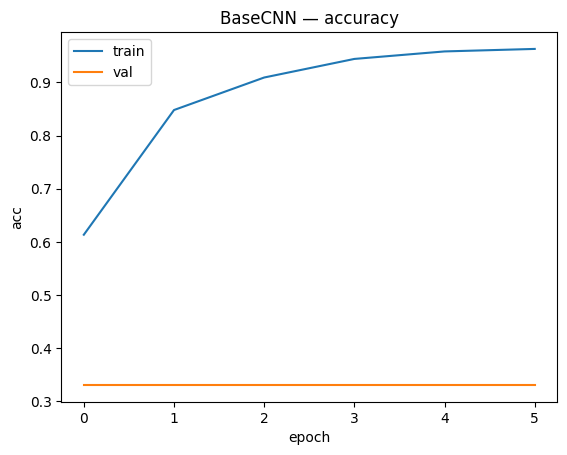

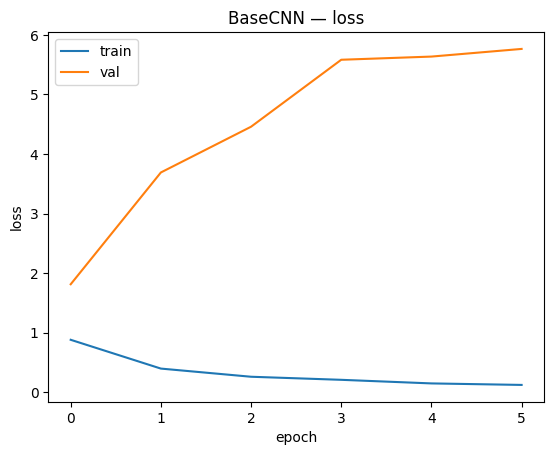

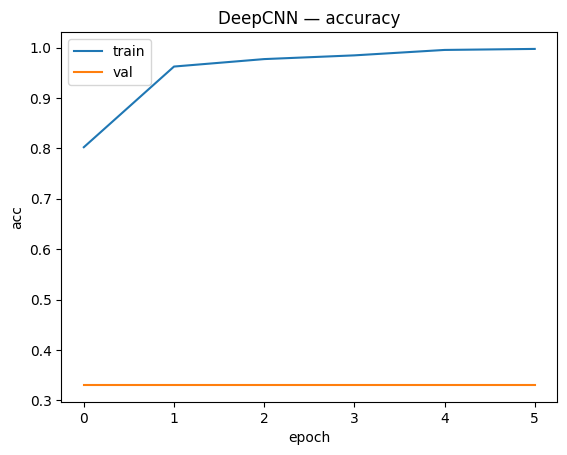

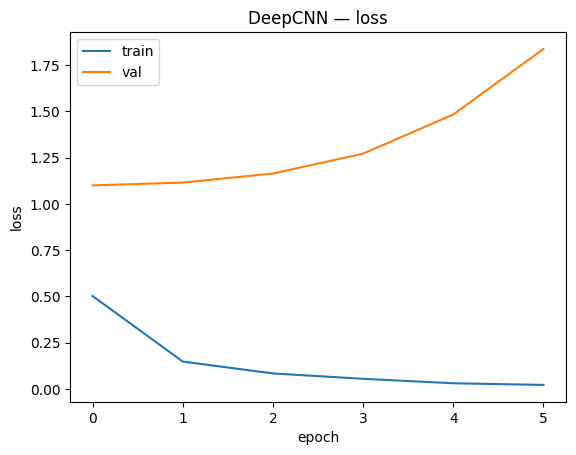

In [32]:
# Save training curves (accuracy & loss) for the report
# I persist curves as PNGs so I can discuss over/underfitting in the PDF.

import matplotlib.pyplot as plt, os
os.makedirs("reports", exist_ok=True)

def plot_hist(h, name):
    plt.figure(); plt.plot(h['accuracy']); plt.plot(h['val_accuracy'])
    plt.title(f'{name} — accuracy'); plt.xlabel('epoch'); plt.ylabel('acc')
    plt.legend(['train','val']); plt.savefig(f'reports/{name}_acc.png', dpi=150)

    plt.figure(); plt.plot(h['loss']); plt.plot(h['val_loss'])
    plt.title(f'{name} — loss'); plt.xlabel('epoch'); plt.ylabel('loss')
    plt.legend(['train','val']); plt.savefig(f'reports/{name}_loss.png', dpi=150)

for name, hist in histories.items():
    plot_hist(hist, name)

print("I saved curves to reports/*.png")

In [33]:
# 7) Automatic hyperparameter tuning — grid + Stratified K-fold CV (macro-F1)
# I tune BaseCNN on the TRAIN split only and select by mean macro-F1 across folds.

GRID = {
    "lr":    ([1e-3, 3e-4]          if QUICK_RUN else [1e-2, 1e-3, 3e-4]),
    "dr1":   ([0.3, 0.4]            if QUICK_RUN else [0.3, 0.4, 0.5]),
    "batch": ([32]                  if QUICK_RUN else [32, 64]),
}
CV_FOLDS   = 2 if QUICK_RUN else 3
EPOCHS_CV  = 12 if QUICK_RUN else 28

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
results = []

for lr in GRID["lr"]:
    for dr1 in GRID["dr1"]:
        for batch in GRID["batch"]:
            fold_scores = []
            for tr_idx, va_idx in skf.split(Xtr, ytr):
                tf.keras.backend.clear_session()
                ds_tr = make_ds(Xtr[tr_idx], ytr[tr_idx], batch=batch, shuffle=True,  augment=True)
                ds_va = make_ds(Xtr[va_idx], ytr[va_idx], batch=batch, shuffle=False, augment=False)

                m = BaseCNN(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dr1=dr1, dr2=0.5)
                m.compile(optimizer=tf.keras.optimizers.Adam(lr),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])
                cbs = [
                    tf.keras.callbacks.EarlyStopping(patience=(4 if QUICK_RUN else 6), restore_best_weights=True),
                    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
                ]
                m.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS_CV, callbacks=cbs, verbose=0)

                # I compute macro-F1 on the fold validation set.
                y_true, y_pred = [], []
                for xb, yb in ds_va:
                    pr = m.predict(xb, verbose=0).argmax(-1)
                    y_pred.extend(pr.tolist()); y_true.extend(yb.numpy().tolist())
                fold_scores.append(f1_score(y_true, y_pred, average="macro"))

            results.append({
                "lr": lr, "dr1": dr1, "batch": batch,
                "mean_macro_f1": float(np.mean(fold_scores))
            })

# I print the top 5 configs for my report and pick the best one.
results = sorted(results, key=lambda d: d["mean_macro_f1"], reverse=True)
print(json.dumps(results[:5], indent=2))
best = results[0]
best

2025-10-20 17:59:40.990742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-20 18:01:40.279249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-20 18:03:48.630351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-20 18:06:01.030163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-20 18:08:33.373333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-20 18:10:51.424125: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-20 18:13:07.996544: W tensorflow/core/framework/local_rendezvous.cc:404] L

[
  {
    "lr": 0.001,
    "dr1": 0.3,
    "batch": 32,
    "mean_macro_f1": 0.17821608660588048
  },
  {
    "lr": 0.001,
    "dr1": 0.4,
    "batch": 32,
    "mean_macro_f1": 0.16624604606441135
  },
  {
    "lr": 0.0003,
    "dr1": 0.3,
    "batch": 32,
    "mean_macro_f1": 0.16624604606441135
  },
  {
    "lr": 0.0003,
    "dr1": 0.4,
    "batch": 32,
    "mean_macro_f1": 0.16624604606441135
  }
]


2025-10-20 18:15:18.798741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'lr': 0.001, 'dr1': 0.3, 'batch': 32, 'mean_macro_f1': 0.17821608660588048}

In [36]:
# 8) Final model — train on train+val, evaluate once on test (full metrics)
# I retrain the best hyperparameters on TRAIN+VAL and do a single held-out TEST evaluation.

# I combine train + val.
X_all_tr = np.concatenate([Xtr, Xva]); y_all_tr = np.concatenate([ytr, yva])
ds_all = make_ds(X_all_tr, y_all_tr, batch=best['batch'], shuffle=True, augment=True)

final = BaseCNN(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dr1=best['dr1'], dr2=0.5)
final.compile(optimizer=tf.keras.optimizers.Adam(best['lr']),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final.fit(
    ds_all,
    epochs=(18 if QUICK_RUN else 50),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=(6 if QUICK_RUN else 8), restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ],
    verbose=1
)

if not RUN_FINAL_TEST:
    print("I skip FINAL TEST now to avoid leakage. When ready, I set RUN_FINAL_TEST=True and re-run this cell.")
else:
    Xte, yte = load_split_list("splits/test.txt")
    ds_te = make_ds(Xte, yte, batch=best['batch'], shuffle=False, augment=False)

    y_true, y_pred = [], []
    for xb, yb in ds_te:
        pr = final.predict(xb, verbose=0).argmax(-1)
        y_pred.extend(pr.tolist()); y_true.extend(yb.numpy().tolist())

    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

    # I record some misclassifications for error analysis.
    mistakes = [(i, t, p) for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]
    print("Misclassified:", len(mistakes))
    for j, (idx, t, p) in enumerate(mistakes[:10]):
        print(f"{j}: true={CLASSES[t]} pred={CLASSES[p]}")

Epoch 1/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5002 - loss: 1.1300 - learning_rate: 0.0010
Epoch 2/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.7844 - loss: 0.5307 - learning_rate: 0.0010
Epoch 3/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9244 - loss: 0.2698 - learning_rate: 0.0010
Epoch 4/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.9365 - loss: 0.2019 - learning_rate: 0.0010
Epoch 5/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9212 - loss: 0.2312 - learning_rate: 0.0010
Epoch 6/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9503 - loss: 0.1605 - learning_rate: 0.0010
Epoch 7/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9649 - loss: 0.1312 - learning_rate: 0.0010
Epoch 8/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.9687 - loss: 0.1133 - learning_rate: 0.0010
Epoch 9/18
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9697 - loss: 0.0882 - learning_rate: 0.0010
Epoch 10/1

Test classification report:
              precision    recall  f1-score   support

       paper     0.9130    0.9813    0.9459       107
        rock     0.9902    0.9266    0.9573       109
    scissors     0.9911    0.9823    0.9867       113

    accuracy                         0.9635       329
   macro avg     0.9648    0.9634    0.9633       329
weighted avg     0.9654    0.9635    0.9637       329



2025-10-20 18:47:23.621631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


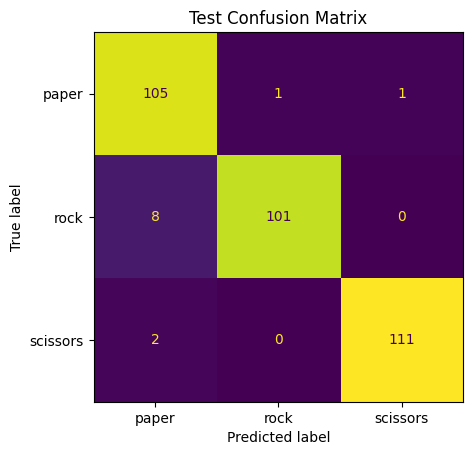

Saved to reports/test_confusion_matrix.png


In [37]:
# 9)  Save test confusion matrix plot (for the PDF)
# I save the confusion matrix figure to include in the report.

import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Ensure the trained final model exists (from Cell 8)
if 'final' not in globals():
    raise RuntimeError("Final model not found. Run Cell 8 (final training) first.")

# Load the held-out test split and build the dataset
Xte, yte = load_split_list("splits/test.txt")
bsz = best['batch'] if ('best' in globals() and 'batch' in best) else 32
ds_te = make_ds(Xte, yte, batch=bsz, shuffle=False, augment=False)

# Predict on the test set
y_true, y_pred = [], []
for xb, yb in ds_te:
    pr = final.predict(xb, verbose=0).argmax(-1)
    y_pred.extend(pr.tolist())
    y_true.extend(yb.numpy().tolist())

# Full metrics (accuracy, precision, recall, F1 per class)
print("Test classification report:")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

# Confusion matrix — show and save
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
ConfusionMatrixDisplay(cm, display_labels=CLASSES).plot(ax=ax, values_format='d', colorbar=False)
ax.set_title('Test Confusion Matrix')

os.makedirs("reports", exist_ok=True)
fig.savefig("reports/test_confusion_matrix.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved to reports/test_confusion_matrix.png")